# Исследовательский анализ данных и предобработка

Импорт необходимых библиотек

In [3]:
import datetime as dt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Загрузка данных в формат DataFrame и изменение названий колонок в snake_case

In [2]:
df = pd.read_csv('data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [3]:
def change_df():
	result = df.groupby(['region', 'device', 'channel']).size().to_dict()
	(region, device, channel), count = sorted(result.items(), key=lambda x: x[1], reverse=True)[0]

	df['region'] = df['region'].fillna(region)
	df['device'] = df['device'].fillna(device)
	df['channel'] = df['channel'].fillna(channel)


change_df()

Проверка данных на дубликаты, в том числе на неявные дубликаты в категориальных данных

In [4]:
regions = set()
devices = set()
channels = set()
result = df.groupby(['region', 'device', 'channel']).size().to_dict().keys()
for region, device, channel in result:
	regions.add(region)
	devices.add(device)
	channels.add(channel)

print(regions)
print(devices)
print(channels)

{'UК', 'UK', 'Frаnce', 'France', 'United States', 'germany', 'Franсe', 'Unjted States', 'Germany', 'Frаncе'}
{'Mac', 'PC', 'Android', 'android', 'iPhone'}
{'контексная реклама', 'organic', 'социальные сети', 'реклама у блогеров', 'email-рассылки', 'контекстная реклама'}


Изменение дублирующихся категорий, удаление дубликатов-записей

In [5]:
def change_promo_code(promo):
	if promo not in [1, 0] and pd.notnull(promo):
		return 1
	return promo


def change_region(region):
	if region in ('UК', 'UK'):
		return 'UK'
	if region in ('Unjted States', 'United States'):
		return 'United States'
	if region in ('Franсe', 'France', 'Frаncе', 'Frаnce'):
		return 'France'
	if region in ('germany', 'Germany'):
		return 'Germany'
	return region


def change_device(device):
	if device in ('android', 'Android'):
		return 'Android'
	return device


def change_channel(channel):
	if channel in ('контексная реклама', 'контекстная реклама'):
		return 'контекстная реклама'
	return channel


# Удаление неявных дубликатов категориальных данных
def delete_duplicates_from_df():
	df.drop_duplicates(inplace=True)
    
	df['region'] = df['region'].apply(change_region)
	df['device'] = df['device'].apply(change_device)
	df['channel'] = df['channel'].apply(change_channel)

    # А ещё встречаются данные с promo_code в 0.87 или вроде того. Можно расценивать их как неправильное заполнение, 
    # поменяем их на 1
	df['promo_code'] = df['promo_code'].apply(change_promo_code)


delete_duplicates_from_df()

Перевод тип данных столбцов с датой и временем в соответствующий формат при необходимости (pd.to_datetime())

In [6]:
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
# df['sessiondurationsec'] = pd.to_timedelta(df['sessiondurationsec'], unit='seconds')
df['sessiondurationsec'] = df['sessiondurationsec'].astype(float).round()
df['session_date'] = pd.to_datetime(df['session_date'])

In [7]:
def count_revenue():
	result_revenue = []
	for i in range(df.shape[0]):
		promo = df.iloc[i][-1]
		if pd.notnull(promo):
			if promo == 0:
				result_revenue.append(df.iloc[i][-3])
			else:
				result_revenue.append(round(df.iloc[i][-3] * 0.9))
		else:
			result_revenue.append(df.iloc[i][-1])

	df['result_revenue'] = result_revenue


count_revenue()

C:\Users\Kseni\AppData\Local\Temp\ipykernel_6412\1957073304.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  promo = df.iloc[i][-1]
C:\Users\Kseni\AppData\Local\Temp\ipykernel_6412\1957073304.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_revenue.append(df.iloc[i][-3])
C:\Users\Kseni\AppData\Local\Temp\ipykernel_6412\1957073304.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_revenue.append(df.iloc[i][-1])


Определить исследуемый период, весь ли период брать для исследования или нет?

Обратимся к [диаграмме распределения количества покупок по месяцам](img/lineplot/month_shared_sales_bairplot.png). На ней видно, что наибольшая активность наблюдается в августе, наименьшая в мае, чуть больше в сентябре. Возможно, в мае рекламу компания ещё не запустила. А вот в сентябре количество покупок уменьшилось практически вдвое относительно предыдущего месяца. Возможно, компания прекратила выпуск рекламы по одному из каналов или сразу по нескольким каналам.

Проверка данных на выбросы и адекватность данных

In [8]:
print(df.groupby('result_revenue')['result_revenue'].value_counts())

result_revenue
1.0           2
4499.0       57
4999.0      135
5399.0       17
5999.0       49
8999.0        7
9999.0       11
90000.0       1
100000.0      3
Name: count, dtype: int64


[histogram_after_checking_blowouts](img/blowouts/histogram_after_checking_blowouts.png)

In [9]:
print(df.describe())

            user_id                  session_start  \
count  1.009000e+03                           1009   
mean   5.072303e+11  2019-08-06 10:05:13.027750144   
min    7.687107e+08            2019-05-01 00:06:40   
25%    2.478235e+11            2019-06-24 18:55:43   
50%    5.026832e+11            2019-08-11 01:53:24   
75%    7.711474e+11            2019-09-22 09:20:56   
max    9.999447e+11            2019-10-31 22:56:17   
std    2.941526e+11                            NaN   

                         session_end  sessiondurationsec  \
count                           1009         1009.000000   
mean   2019-08-06 10:35:34.993062656         1821.965312   
min              2019-05-01 00:07:06            0.000000   
25%              2019-06-24 21:02:35          536.000000   
50%              2019-08-11 02:36:03         1228.000000   
75%              2019-09-22 09:46:01         2522.000000   
max              2019-10-31 23:42:27        12388.000000   
std                              

In [10]:
def check_blowouts():
    h = df['result_revenue'].quantile(q=[0.75, 0.25]).tolist()
    h = h[0] - h[1]
    median = df['result_revenue'].median()
    # df['result_revenue'] = df['result_revenue'].apply(
	# 	lambda x: x if (median - 3 * h <= x <= median + 3 * h) or (pd.isnull(x))
	# 	else -1
	# )
    df['result_revenue'] = df['result_revenue'].apply(
        lambda x: x if (4499 <= x <= 9999) or (pd.isnull(x))
        else -1)
    return df[df['result_revenue'] != -1]


df = check_blowouts()
# sns.boxplot(df['sessiondurationsec'])
# plt.title('Оценка выбросов по длительности сессии', fontsize=12)
# plt.savefig('img/blowouts/boxplot_sessionduration.png')

Смотря на [график длительности сесии](boxplot_sessionduration), можно заметить, что околонулевая длителньость сессии не является выбросом. 
Да и пользователь может зайти на сайт и сразу же выйти (миссклик). Это реалистичная ситуация.
А вот длительность сессии в несколько часов интересна.

In [11]:
print(df[['sessiondurationsec', 'channel', 'result_revenue']].sort_values(by='sessiondurationsec').tail(10))

     sessiondurationsec             channel  result_revenue
210              8655.0  реклама у блогеров             NaN
254              8783.0     социальные сети             NaN
298              9098.0     социальные сети          4999.0
878              9622.0             organic          5999.0
761              9812.0     социальные сети             NaN
844              9930.0     социальные сети             NaN
289             10134.0             organic             NaN
822             10183.0             organic             NaN
126             10656.0             organic          4999.0
35              12388.0  реклама у блогеров             NaN


In [12]:
print(df[['sessiondurationsec', 'channel', 'result_revenue']].sort_values(by='sessiondurationsec').tail(10))

     sessiondurationsec             channel  result_revenue
210              8655.0  реклама у блогеров             NaN
254              8783.0     социальные сети             NaN
298              9098.0     социальные сети          4999.0
878              9622.0             organic          5999.0
761              9812.0     социальные сети             NaN
844              9930.0     социальные сети             NaN
289             10134.0             organic             NaN
822             10183.0             organic             NaN
126             10656.0             organic          4999.0
35              12388.0  реклама у блогеров             NaN


[boxplot_with_blowouts](img/blowouts/boxplot_with_blowouts.png) и [boxplot_without_blowouts](img/blowouts/boxplot_without_blowouts.png)

[boxplot_without_blowouts](img/blowouts/boxplot_without_blowouts_version2.png)

Добавление столбца с указанием времени суток визита (утро 06:00-09:59, день 10:00-16:59, вечер 17:00-21:59, ночь 22:00-05:59)

In [13]:
def add_time_factor(x):
	if dt.time.fromisoformat('10:00') > x >= dt.time.fromisoformat('06:00'):
		return 'утро'
	if dt.time.fromisoformat('17:00') > x >= dt.time.fromisoformat('10:00'):
		return 'день'
	if dt.time.fromisoformat('22:00') > x >= dt.time.fromisoformat('17:00'):
		return 'вечер'
	if x >= dt.time.fromisoformat('22:00') or x < dt.time.fromisoformat('06:00'):
		return 'ночь'


df['time_factor'] = df['session_start'].dt.time.apply(add_time_factor)

Добавление столбца “payer” с информацией о том, является ли пользователь платящим или нет.

In [14]:
def add_payer_factor():
	payers = df[df['result_revenue'].notnull()]['user_id'].tolist()

	df['payer'] = df['user_id'].apply(lambda x: 1 if x in payers else 0)


add_payer_factor()

In [15]:
# df.to_csv('resolvedData.csv', index=False)

Провести аналитический и графический анализ данных

Доля продаж по регионам

{'France': 120877.0, 'Germany': 128276.0, 'UK': 171769.0, 'United States': 1069102.0}


Text(0.5, 1.0, 'Доля продаж по регионам')

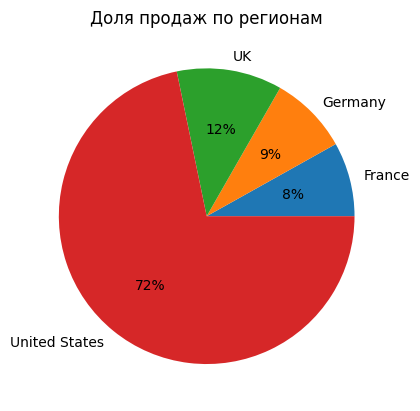

In [16]:
data = df.groupby('region')['result_revenue'].sum().to_dict()
plt.pie(x=data.values(), labels=data.keys(), autopct='%1.0f%%')
print(data)
plt.title('Доля продаж по регионам', fontsize=12)

Доля продаж по источникам

{'email-рассылки': 31994.0, 'organic': 456316.0, 'контекстная реклама': 215158.0, 'реклама у блогеров': 145273.0, 'социальные сети': 641283.0}


Text(0.5, 1.0, 'Доля продаж по источникам')

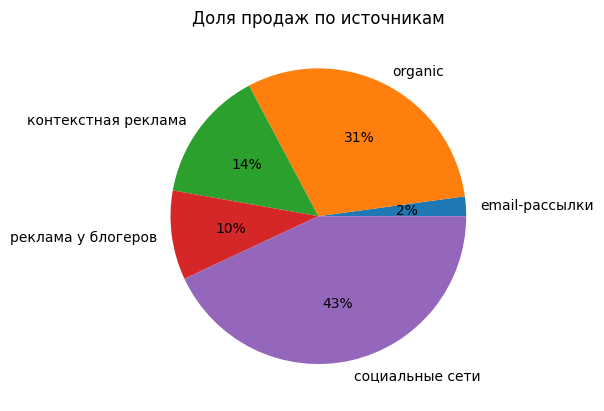

In [17]:
data = df.groupby('channel')['result_revenue'].sum().to_dict()
plt.pie(x=data.values(), labels=data.keys(), autopct='%1.0f%%')
print(data)
plt.title('Доля продаж по источникам', fontsize=12)

Доля продаж по устройствам

{'Android': 379429.0, 'Mac': 312842.0, 'PC': 263652.0, 'iPhone': 534101.0}


Text(0.5, 1.0, 'Доля продаж по устройствам')

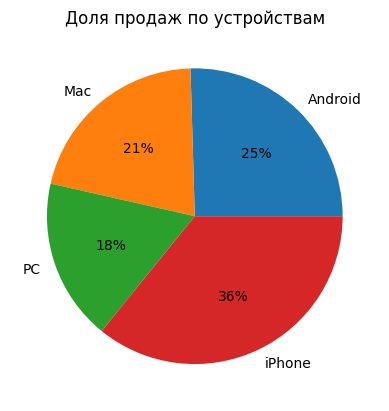

In [18]:
data = df.groupby('device')['result_revenue'].sum().to_dict()
plt.pie(x=data.values(), labels=data.keys(), autopct='%1.0f%%')
print(data)
plt.title('Доля продаж по устройствам', fontsize=12)

Количество пользователей с разбивкой на платящих/не платящих по регионам

                     count
region        payer       
France        0         78
              1         23
Germany       0         78
              1         24
UK            0         83
              1         31
United States 0        486
              1        200


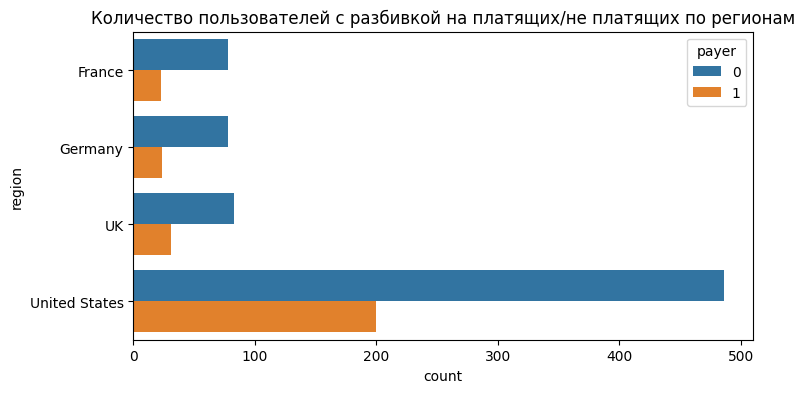

In [19]:
data = df.groupby('region')['payer'].value_counts().to_frame()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.barplot(data=data, y='region', x='count', hue='payer')
plt.title('Количество пользователей с разбивкой на платящих/не платящих по регионам', fontsize=12)
print(data)

Количество пользователей с разбивкой на платящих/не платящих по устройствам

               count
device  payer       
Android 0        163
        1         72
Mac     0        142
        1         58
PC      0        155
        1         48
iPhone  0        265
        1        100


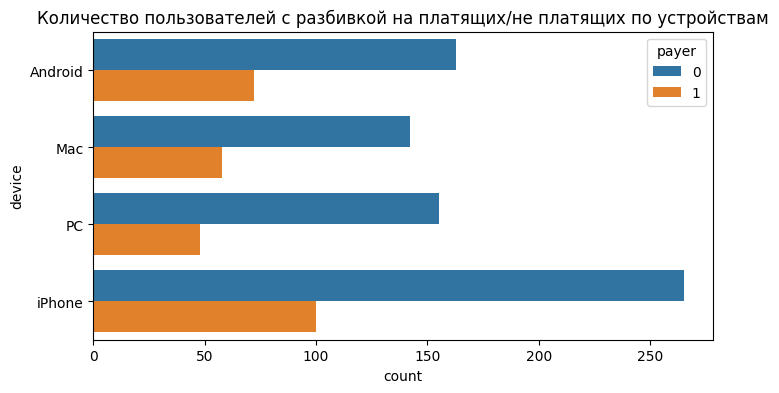

In [20]:
data = df.groupby('device')['payer'].value_counts().to_frame()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.barplot(data=data, y='device', x='count', hue='payer')
plt.title('Количество пользователей с разбивкой на платящих/не платящих по устройствам', fontsize=12)
print(data)

Количество пользователей с разбивкой на платящих/не платящих по источникам

                           count
channel             payer       
email-рассылки      0         17
                    1          6
organic             0        259
                    1         84
контекстная реклама 0        117
                    1         42
реклама у блогеров  0         71
                    1         27
социальные сети     0        261
                    1        119


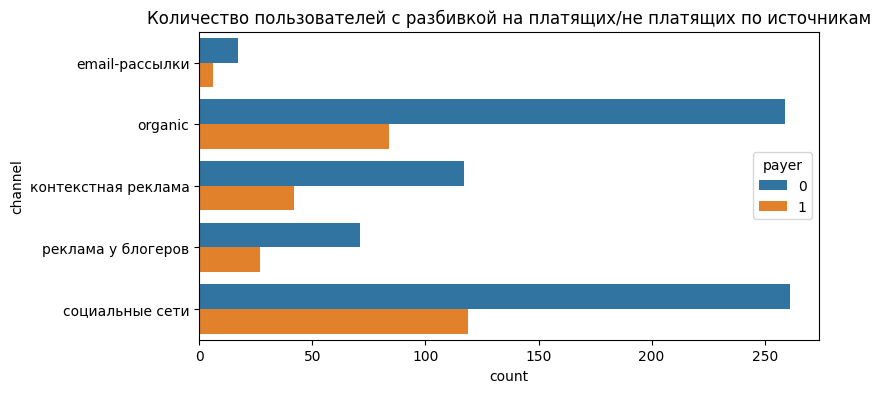

In [21]:
data = df.groupby('channel')['payer'].value_counts().to_frame()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.barplot(data=data, y='channel', x='count', hue='payer')
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам', fontsize=12)
print(data)

Графики, показывающие есть ли сезонность в продажах по месяцам, дням недели, времени суток

{5: 154574.0, 6: 267551.0, 7: 226757.0, 8: 396027.0, 9: 196362.0, 10: 248753.0}


Text(0.5, 1.0, 'Диаграмма сезонности покупок по месяцам')

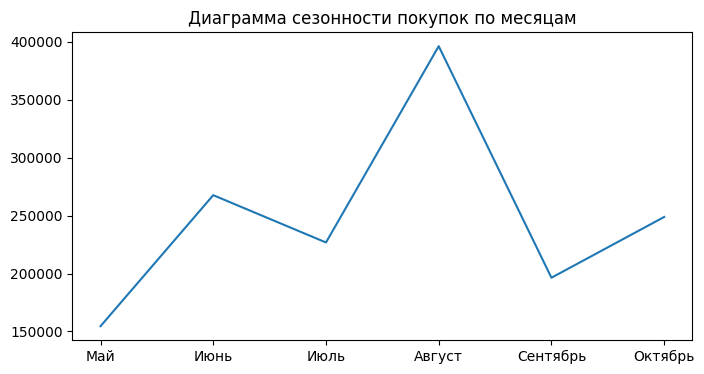

In [22]:
data = df.groupby('month')['result_revenue'].sum().to_dict()
print(data)

month_dict = {
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь'
}


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=[month_dict[i] for i in data.keys()], y=data.values())
plt.title('Диаграмма сезонности покупок по месяцам', fontsize=12)

{5: 140, 6: 154, 7: 147, 8: 191, 9: 186, 10: 185}


Text(0.5, 1.0, 'Диаграмма сезонности количества покупок по месяцам')

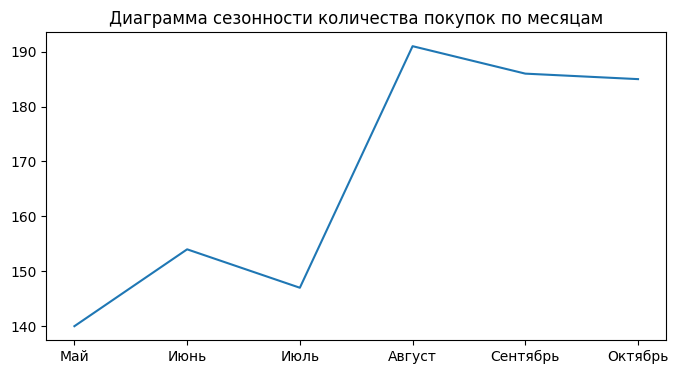

In [23]:
data = df.groupby('month')['month'].value_counts().to_dict()
print(data)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=[month_dict[i] for i in data.keys()], y=data.values())
plt.title('Диаграмма сезонности количества покупок по месяцам', fontsize=12)

{1: 209260.0, 2: 205661.0, 3: 205664.0, 4: 199364.0, 5: 248153.0, 6: 220558.0, 7: 201364.0}


Text(0.5, 1.0, 'Диаграмма сезонности покупок по дням недели')

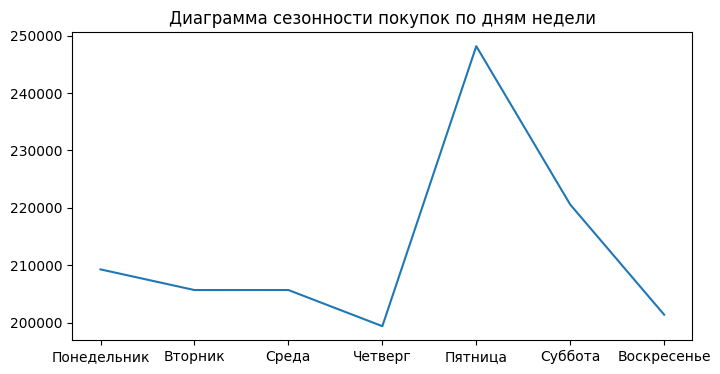

In [24]:
data = df.groupby('day')['result_revenue'].sum().to_dict()
print(data)


day_dict = {
    1: 'Понедельник',
    2: 'Вторник',
    3: 'Среда',
    4: 'Четверг',
    5: 'Пятница',
    6: 'Суббота',
    7: 'Воскресенье'
}


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=[day_dict[i] for i in data.keys()], y=data.values())
plt.title('Диаграмма сезонности покупок по дням недели', fontsize=12)

{1: 158, 2: 131, 3: 128, 4: 135, 5: 135, 6: 158, 7: 158}


Text(0.5, 1.0, 'Диаграмма сезонности количества покупок по дням')

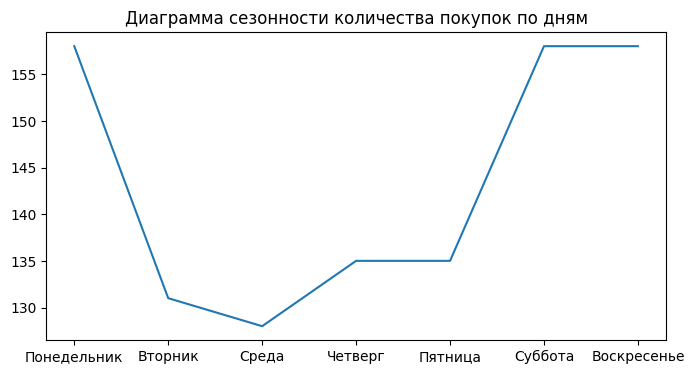

In [25]:
data = df.groupby('day')['day'].value_counts().to_dict()
print(data)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=[day_dict[i] for i in data.keys()], y=data.values())
plt.title('Диаграмма сезонности количества покупок по дням', fontsize=12)

{'вечер': 316842.0, 'день': 396327.0, 'ночь': 522705.0, 'утро': 254150.0}


Text(0.5, 1.0, 'Диаграмма сезонности покупок по времени суток')

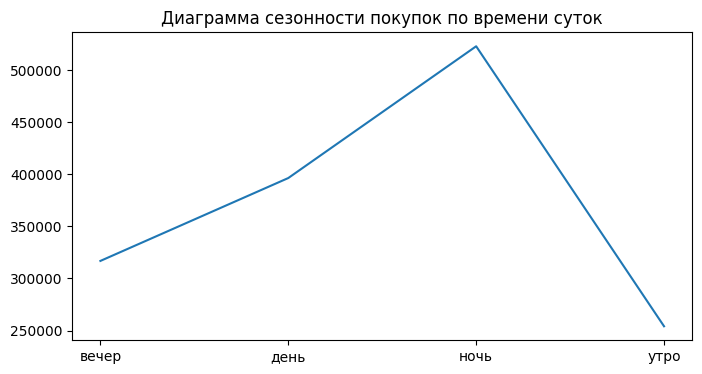

In [26]:
data = df.groupby('time_factor')['result_revenue'].sum().to_dict()
print(data)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=data.keys(), y=data.values())
plt.title('Диаграмма сезонности покупок по времени суток', fontsize=12)

{'вечер': 214, 'день': 279, 'ночь': 327, 'утро': 183}


Text(0.5, 1.0, 'Диаграмма сезонности количества покупок по времени суток')

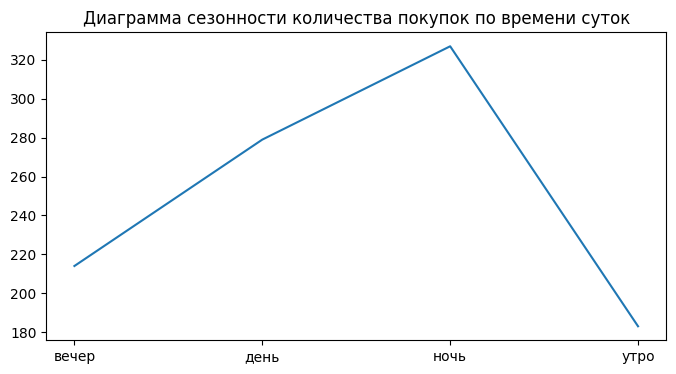

In [27]:
data = df.groupby('time_factor')['time_factor'].value_counts().to_dict()
print(data)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=data.keys(), y=data.values())
plt.title('Диаграмма сезонности количества покупок по времени суток', fontsize=12)

{'вечер': 316842.0, 'день': 396327.0, 'ночь': 522705.0, 'утро': 254150.0}


Text(0.5, 1.0, 'Диаграмма сезонности покупок по времени суток')

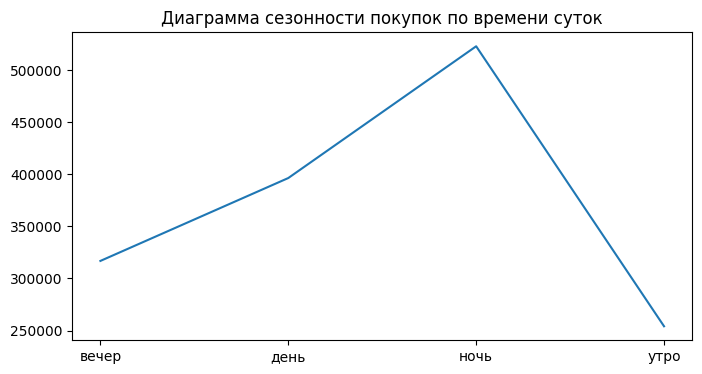

In [28]:
data = df.groupby('time_factor')['result_revenue'].sum().to_dict()
print(data)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=data.keys(), y=data.values())
plt.title('Диаграмма сезонности покупок по времени суток', fontsize=12)

{'вечер': 214, 'день': 279, 'ночь': 327, 'утро': 183}


Text(0.5, 1.0, 'Диаграмма сезонности количества покупок по времени суток')

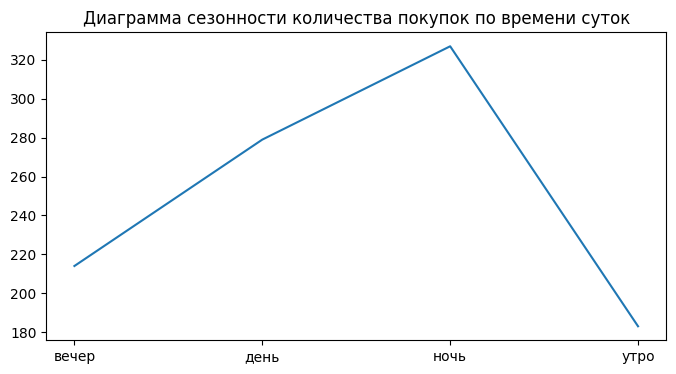

In [29]:
data = df.groupby('time_factor')['time_factor'].value_counts().to_dict()
print(data)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.lineplot(x=data.keys(), y=data.values())
plt.title('Диаграмма сезонности количества покупок по времени суток', fontsize=12)

Диаграмма количества покупок по типу оплаты

{'Cash': 60, 'Credit card': 34, 'Debit card': 35, 'E-wallet': 65, 'Mobile payments': 82}


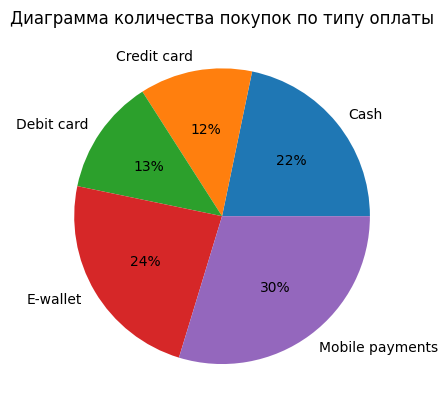

In [30]:
data = df.groupby('payment_type')['payment_type'].value_counts().to_dict()
plt.pie(x=data.values(), labels=data.keys(), autopct='%1.0f%%')
plt.title('Диаграмма количества покупок по типу оплаты', fontsize=12)
print(data)

{'Cash': 60, 'Credit card': 34, 'Debit card': 35, 'E-wallet': 65, 'Mobile payments': 82}


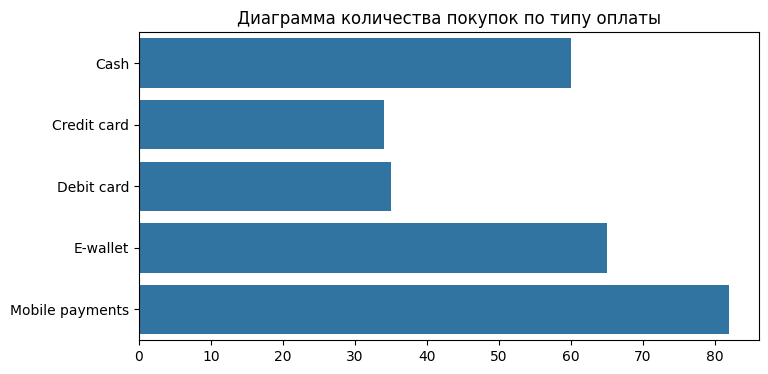

In [31]:
data = df.groupby('payment_type')['payment_type'].value_counts().to_dict()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.barplot(y=data.keys(), x=data.values())
plt.title('Диаграмма количества покупок по типу оплаты', fontsize=12)
print(data)

# Проведение расчётов

Рассчитать средний чек.

In [32]:
def average_order_value(df):
    # Т.к. мы избавились от выбросов, то можно использовать среднее, а не медианное
    a = df['revenue'].mean()
    print('Средний чек:', round(a))


average_order_value(df)

Средний чек: 5564


Сколько покупок в среднем совершает 1 пользователь?

In [33]:
def average_purchases_per_user(df):
    b = df.groupby('user_id')['order_dt'].count().mean()
    print('Среднее количество покупок на 1 пользователя:', round(b, 3))
    print(f'Покупка в среднем встречается раз в {round(1 / b, 1)} пользователя')


average_purchases_per_user(df)

Среднее количество покупок на 1 пользователя: 0.278
Покупка в среднем встречается раз в 3.6 пользователя


Рассчитать среднюю продолжительность сессии по рекламным каналам.

In [34]:
def average_session_duration_by_channel(df):
    с = df.groupby('channel')['sessiondurationsec'].mean().astype(int)
    result = с.rename_axis('канал').reset_index(name='средняя продолжительность сессии')
    print('Средняя продолжительность сессии по рекламным каналам')
    return result


average_session_duration_by_channel(df)

Средняя продолжительность сессии по рекламным каналам


,канал,средняя продолжительность сессии
0,email-рассылки,1919
1,organic,1877
2,контекстная реклама,1961
3,реклама у блогеров,1870
4,социальные сети,1705


Рассчитать среднюю продолжительность сессии по типу устройства.

In [35]:
def average_session_duration_by_device(df):
    d = df.groupby('device')['sessiondurationsec'].mean().astype(int)
    result = d.rename_axis('устройство').reset_index(name='средняя продолжительность сессии')
    print('Средняя продолжительность сессии по типу устройства')
    return result


average_session_duration_by_device(df)

Средняя продолжительность сессии по типу устройства


,устройство,средняя продолжительность сессии
0,Android,1900
1,Mac,1775
2,PC,1952
3,iPhone,1735


Определить топ-3 рекламных канала по среднему чеку.

In [36]:
def top_3_channels_by_average_order_value(df):
    e = df.groupby('channel')['revenue'].mean().astype(int).sort_values(ascending=False).head(3)
    f = e.rename_axis('канал').reset_index(name='средний чек')
    print('Топ-3 рекламных каналов по среднему чеку')
    return f


top_3_channels_by_average_order_value(df)

Топ-3 рекламных каналов по среднему чеку


,канал,средний чек
0,социальные сети,5640
1,organic,5606
2,email-рассылки,5499


Определить топ-3 региона по среднему чеку.

In [37]:
def top_3_regions_by_average_order_value(df):
    # Группировка данных по региону, вычисление среднего чека и сортировка результатов
    avg_order_value_by_region = df.groupby('region')['revenue'].mean().astype(int).sort_values(ascending=False).head(3)
    print('Топ-3 региона по среднему чеку')
    return avg_order_value_by_region.rename_axis('регион').reset_index(name='средний чек')


top_3_regions_by_average_order_value(df)

Топ-3 региона по среднему чеку


,регион,средний чек
0,UK,5644
1,United States,5579
2,Germany,5499


Определить топ-3 месяца по среднему чеку с разбивкой по регионам.

In [38]:
def top_3_months_by_region(df):
    # 1. Создание датасета из df - удаление всех строк с пустым значением revenue
    df_cleaned = df.dropna(subset=['revenue'])

    # 2. группировка по 'month' и 'region', расчет среднего 'revenue' и сортировка
    average_revenue = df_cleaned.groupby(['month', 'region'])['revenue'].mean().astype(int).reset_index()

    # 3. average_revenue сортированный от большего к меньшему месяцу
    sorted_months = average_revenue.sort_values(by='revenue', ascending=False)['month'].unique()
    average_revenue_sorted = average_revenue.set_index('month').loc[sorted_months].reset_index()

    # 4. группировка только по 'month' для нахождения топ-3 месяцев
    top_3_months = average_revenue.groupby('month')['revenue'].mean().nlargest(3).index

    print("\nТоп-3 месяца с наибольшим средним доходом по регионам:")
    top_3_months_by_region = average_revenue[average_revenue['month'].isin(top_3_months)]

    print(top_3_months_by_region)


top_3_months_by_region(df)


Топ-3 месяца с наибольшим средним доходом по регионам:
    month         region  revenue
0       5         France     5999
1       5        Germany     4999
2       5             UK     5999
3       5  United States     6449
4       6         France     5570
5       6        Germany     5799
6       6             UK     5427
7       6  United States     5665
8       7         France     4999
9       7        Germany     7499
10      7             UK     5199
11      7  United States     5341


Посчитать MAU* по каждому месяцу с разбивкой по рекламным каналам и выделить топ-3 рекламных каналов по количеству уникальных пользователей в месяц.
Monthly Active Users — это количество уникальных пользователей за месяц.

In [39]:
# 1. Посчитать MAU по каждому 'month' с разбивкой по 'channel'
mau_by_channel = df.groupby(['month', 'channel'])['user_id'].nunique().reset_index()
mau_by_channel.columns = ['month', 'channel', 'MAU']

print("MAU (Monthly Active Users) по каждому месяцу с разбивкой по каналам:")
print(mau_by_channel)

# 2. Вывести топ-3 'channel' с максимальным MAU
top_3_channels_by_mau = mau_by_channel.groupby('channel')['MAU'].sum().nlargest(3).index

print("\nТоп-3 канала с максимальным MAU:")
print(top_3_channels_by_mau)

MAU (Monthly Active Users) по каждому месяцу с разбивкой по каналам:
    month              channel  MAU
0       5       email-рассылки    7
1       5              organic   73
2       5  контекстная реклама    8
3       5   реклама у блогеров   12
4       5      социальные сети   40
5       6       email-рассылки    1
6       6              organic   59
7       6  контекстная реклама   28
8       6   реклама у блогеров   13
9       6      социальные сети   53
10      7       email-рассылки    3
11      7              organic   46
12      7  контекстная реклама   24
13      7   реклама у блогеров   15
14      7      социальные сети   58
15      8       email-рассылки    4
16      8              organic   60
17      8  контекстная реклама   35
18      8   реклама у блогеров   20
19      8      социальные сети   72
20      9       email-рассылки    2
21      9              organic   58
22      9  контекстная реклама   38
23      9   реклама у блогеров   20
24      9      социальные сети 

Составить таблицу в которой будет указано по рекламным каналам: 
количество пользователей, количество уникальных пользователей, 
количество платящих пользователей, 
сумма продаж и определить какой источника “принес” 
больше всего платящих пользователей и большую сумму продаж.

In [40]:
def channel_metrics(df):
    # Группировка данных по рекламным каналам
    # Колонки: количество пользователей, количество уникальных пользователей, количество платящих пользователей
    channel_stats = df.groupby('channel').agg({
        'user_id': ['count', 'nunique', lambda x: x[df['payment_type'].isnull() == False].nunique()],  
        'revenue': 'sum'  # Сумма продаж
    }).reset_index()

    # Переименование столбцов для ясности
    channel_stats.columns = ['channel', 'total_users', 'unique_users', 'paying_users', 'total_revenue']

    # Процентное соотношение платящих пользователей ко всем пользователям
    channel_stats['%, paying_users / total_users'] = channel_stats['paying_users'].apply(
        lambda x: round(x / channel_stats.loc[channel_stats['paying_users'] == x]['unique_users'].iloc[0] * 100, 1))

    # Определение источника, принесшего наибольшее соотношение платящих пользователей
    max_paying_users_channel_percent = channel_stats.loc[channel_stats['%, paying_users / total_users'].idxmax(), 'channel']
    
    # Определение источника, принесшего больше всего платящих пользователей
    max_paying_users_channel = channel_stats.loc[channel_stats['paying_users'].idxmax(), 'channel']

    # Определение источника, принесшего большую сумму продаж
    max_revenue_channel = channel_stats.loc[channel_stats['total_revenue'].idxmax(), 'channel']

    print(channel_stats)
    print("Больше всего платящих пользователей принесли", max_paying_users_channel)
    print("Большую сумму продаж принесли", max_revenue_channel)
    print("Наибольшее соотношение платящих ко всем пользователям принесли", max_paying_users_channel_percent)



# Проверка гипотез

Влияет ли тип устройства на количество покупок в день по каждому региону?

In [41]:
import pandas as pd

# чтение данных из файла
data = pd.read_csv('resolvedData.csv')

# группировка данных по региону и типу устройства
grouped_data = data.groupby(['region', 'device'])

# создание нового DataFrame для хранения результатов
result = pd.DataFrame(columns=['region', 'device', 'number_of_day', 'unique_payers'])

# проход по группам данных и подсчет количества уникальных пользователей, совершивших покупки в каждый день
for group_name, group_data in grouped_data:
    region = group_name[0]
    device = group_name[1]
    unique_payers = group_data.groupby('day')['payer'].nunique()
    for date, count in unique_payers.items():
        result = result._append({'region': region, 'device': device, 'number_of_day': date, 'unique_payers': count},
                                ignore_index=True)

# построение сводной таблицы
pivot_table = pd.pivot_table(result, values='unique_payers', index=['region', 'device'], columns='number_of_day')

# вывод результатов
print(pivot_table)

number_of_day            1    2    3    4    5    6    7
region        device                                    
France        Android  2.0  2.0  1.0  2.0  2.0  1.0  2.0
              Mac      2.0  1.0  2.0  1.0  1.0  2.0  NaN
              PC       2.0  2.0  2.0  2.0  2.0  2.0  1.0
              iPhone   1.0  2.0  1.0  2.0  1.0  1.0  1.0
Germany       Android  1.0  2.0  2.0  1.0  1.0  2.0  1.0
              Mac      1.0  2.0  1.0  1.0  1.0  2.0  1.0
              PC       1.0  2.0  2.0  2.0  2.0  2.0  2.0
              iPhone   2.0  2.0  1.0  2.0  2.0  2.0  1.0
UK            Android  2.0  2.0  2.0  2.0  2.0  2.0  2.0
              Mac      1.0  1.0  1.0  1.0  1.0  2.0  1.0
              PC       2.0  2.0  2.0  1.0  2.0  2.0  2.0
              iPhone   2.0  2.0  2.0  2.0  2.0  2.0  1.0
United States Android  2.0  2.0  2.0  2.0  2.0  2.0  2.0
              Mac      2.0  2.0  2.0  2.0  2.0  2.0  2.0
              PC       2.0  2.0  2.0  2.0  2.0  2.0  2.0
              iPhone   2.0  2.0

Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

In [42]:
# Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

# чтение данных из файла
data = pd.read_csv('resolvedData.csv')

# группировка данных по региону и типу рекламного канала
grouped_data = data.groupby(['region', 'channel'])

# создание нового DataFrame для хранения результатов
result = pd.DataFrame(columns=['region', 'channel', 'number_of_day', 'unique_payers'])

# проход по группам данных и подсчет количества уникальных пользователей, совершивших покупки в каждый день
for group_name, group_data in grouped_data:
    region = group_name[0]
    channel = group_name[1]
    unique_payers = group_data.groupby('day')['payer'].nunique()
    for date, count in unique_payers.items():
        result = result._append({'region': region, 'channel': channel, 'number_of_day': date, 'unique_payers': count},
                                ignore_index=True)

# построение сводной таблицы
pivot_table = pd.pivot_table(result, values='unique_payers', index=['region', 'channel'], columns='number_of_day')

# вывод результатов
print(pivot_table)

number_of_day                        1    2    3    4    5    6    7
region        channel                                               
France        email-рассылки       2.0  1.0  NaN  NaN  1.0  1.0  2.0
              organic              1.0  2.0  1.0  1.0  1.0  1.0  1.0
              контекстная реклама  2.0  2.0  2.0  2.0  2.0  2.0  1.0
              реклама у блогеров   1.0  2.0  1.0  2.0  2.0  2.0  1.0
Germany       email-рассылки       1.0  NaN  2.0  NaN  NaN  NaN  1.0
              organic              2.0  2.0  2.0  2.0  2.0  2.0  1.0
              контекстная реклама  1.0  2.0  2.0  2.0  2.0  2.0  2.0
              реклама у блогеров   1.0  2.0  2.0  2.0  2.0  1.0  1.0
UK            email-рассылки       NaN  1.0  NaN  NaN  1.0  1.0  2.0
              organic              1.0  1.0  1.0  2.0  2.0  2.0  2.0
              контекстная реклама  2.0  2.0  2.0  1.0  2.0  2.0  1.0
              реклама у блогеров   2.0  1.0  2.0  2.0  2.0  1.0  1.0
United States organic             

Проверить гипотезу о том, что средний чек отличается в зависимости от региона?

In [43]:
# Проверить гипотезу о том, что средний чек отличается в зависимости от региона?

from scipy.stats import ttest_ind

# загрузка данных из файла
data = pd.read_csv('resolvedData.csv')

# удаление строк с пропущенными значениями
data.dropna(inplace=True)

# создание списка уникальных регионов
regions = data['region'].unique()


def test_region_mean(_revenue, region1, region2):
    # выборка значений среднего чека для каждого региона
    r1_revenue = _revenue[data['region'] == region1]
    r2_revenue = _revenue[data['region'] == region2]

    # проведение t-теста
    t, p = ttest_ind(r1_revenue, r2_revenue, equal_var=False)

    # вывод результатов теста
    print(f'{region1} vs {region2}:')
    print(f't-statistic: {t:.3f}')
    print(f'p-value: {p:.3f}')


# выборка значений среднего чека
revenue = data['revenue']

# проведение теста для каждой пары регионов
for i in range(len(regions)):
    for j in range(i+1, len(regions)):
        test_region_mean(revenue, regions[i], regions[j])


United States vs Germany:
t-statistic: 0.341
p-value: 0.735
United States vs France:
t-statistic: 1.348
p-value: 0.182
United States vs UK:
t-statistic: -0.264
p-value: 0.793
Germany vs France:
t-statistic: 0.452
p-value: 0.655
Germany vs UK:
t-statistic: -0.464
p-value: 0.644
France vs UK:
t-statistic: -1.024
p-value: 0.312


Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?

In [44]:
# Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?
from scipy.stats import f_oneway

# загрузка данных из файла
data = pd.read_csv('resolvedData.csv')

# удаление строк с пропущенными значениями
data.dropna(inplace=True)


def test_channel_mean(_revenue, _channels):
    # создание списка выборок значений среднего чека для каждого канала
    samples = [_revenue[data['channel'] == channel] for channel in _channels]

    # проведение ANOVA
    f, p = f_oneway(*samples)

    # вывод результатов теста
    print(f'ANOVA results:')
    print(f'F-statistic: {f:.3f}')
    print(f'p-value: {p:.3f}')


# выборка значений среднего чека
revenue = data['revenue']

# список уникальных рекламных каналов
channels = data['channel'].unique()

# проведение теста
test_channel_mean(revenue, channels)

ANOVA results:
F-statistic: 0.526
p-value: 0.717


Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?

In [45]:
# Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?
from scipy.stats import f_oneway

# загрузка данных из файла
data = pd.read_csv('resolvedData.csv')

# удаление строк с пропущенными значениями
data.dropna(inplace=True)


def test_time_mean(_revenue, _times):
    # создание списка выборок значений среднего чека для каждого времени суток
    samples = [_revenue[data['hour_of_day'] == time] for time in _times]

    # проведение ANOVA
    f, p = f_oneway(*samples)

    # вывод результатов теста
    print(f'ANOVA results:')
    print(f'F-statistic: {f:.3f}')
    print(f'p-value: {p:.3f}')


# выборка значений среднего чека
revenue = data['revenue']

# список уникальных времен суток
times = data['hour_of_day'].unique()

# проведение теста
test_time_mean(revenue, times)


ANOVA results:
F-statistic: 1.419
p-value: 0.101


Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

In [46]:
# Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

# загрузка данных из csv файла
data = pd.read_csv('resolvedData.csv')

# выбор столбцов "SessionDurationSec" и "Revenue"
subset = data[['sessiondurationsec', 'revenue']]

# расчет корреляционной матрицы
corr_matrix = subset.corr()

# вывод корреляционной матрицы
print(corr_matrix)

# вывод коэффициента корреляции между столбцами "SessionDurationSec" и "Revenue"
print(corr_matrix.loc['sessiondurationsec', 'revenue'])

                    sessiondurationsec  revenue
sessiondurationsec             1.00000 -0.01068
revenue                       -0.01068  1.00000
-0.010679946976271643


Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

In [47]:
# Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

# загрузка данных из csv файла
data = pd.read_csv('resolvedData.csv')

# выбор столбцов "SessionDurationSec" и "Revenue"
subset = data[['sessiondurationsec', 'revenue']]

# расчет корреляционной матрицы
corr_matrix = subset.corr()

# вывод корреляционной матрицы
print(corr_matrix)

# вывод коэффициента корреляции между столбцами "SessionDurationSec" и "Revenue"
print(corr_matrix.loc['sessiondurationsec', 'revenue'])

                    sessiondurationsec  revenue
sessiondurationsec             1.00000 -0.01068
revenue                       -0.01068  1.00000
-0.010679946976271643


In [ ]:
# Регрессионное моделирование

-0.03


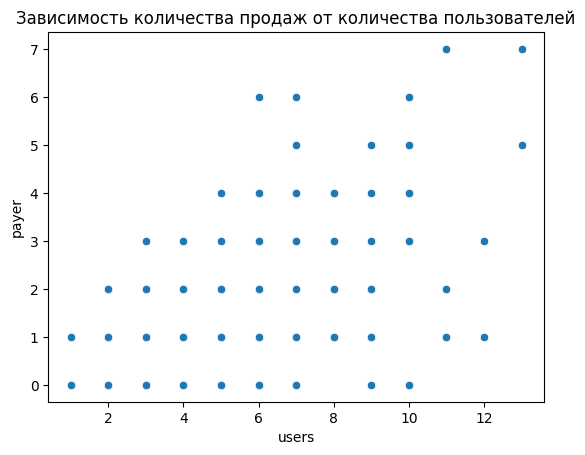

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


df = pd.read_csv('resolvedData.csv', sep=',', decimal=',')
regr_df = df.groupby('session_date')['payer'].sum().reset_index()
regr_df['users'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['users'])
plt.title('Зависимость количества продаж от количества пользователей')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.055


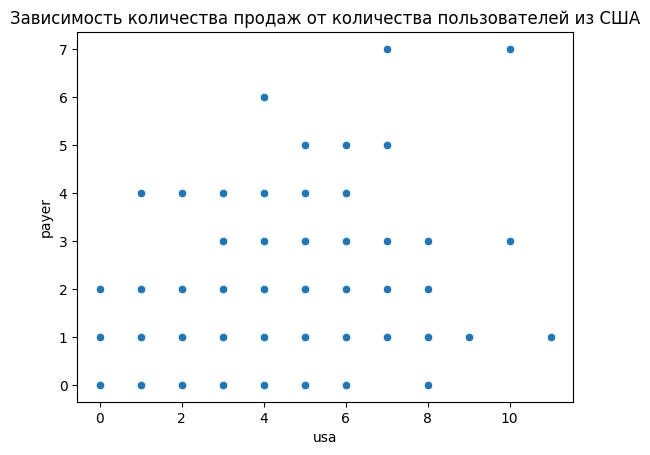

In [49]:
regr_df = regr_df.drop('users', axis=1)
regr_df['usa'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['region'] == 'United States']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['usa'])
plt.title('Зависимость количества продаж от количества пользователей из США')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.04


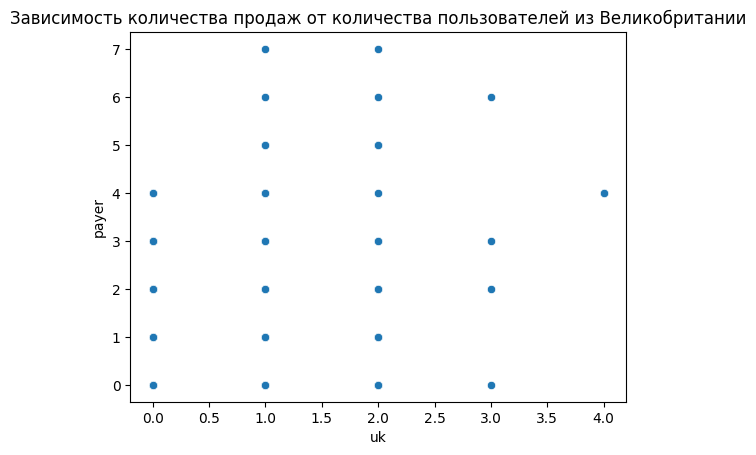

In [50]:
regr_df = regr_df.drop('usa', axis=1)
regr_df['uk'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['region'] == 'UK']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['uk'])
plt.title('Зависимость количества продаж от количества пользователей из Великобритании')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.096


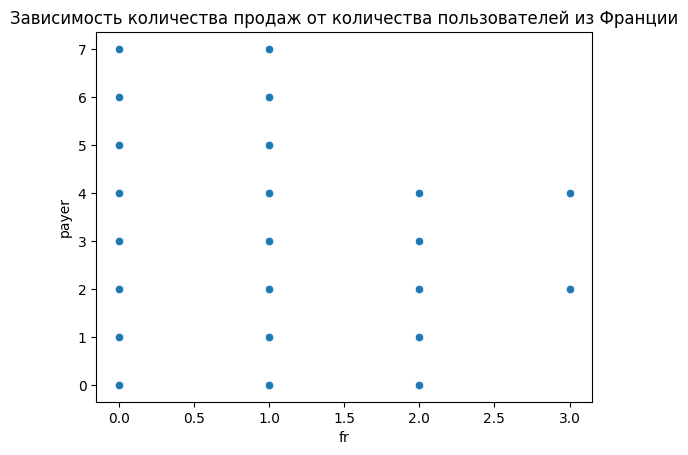

In [51]:
regr_df = regr_df.drop('uk', axis=1)
regr_df['fr'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['region'] == 'France']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['fr'])
plt.title('Зависимость количества продаж от количества пользователей из Франции')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.152


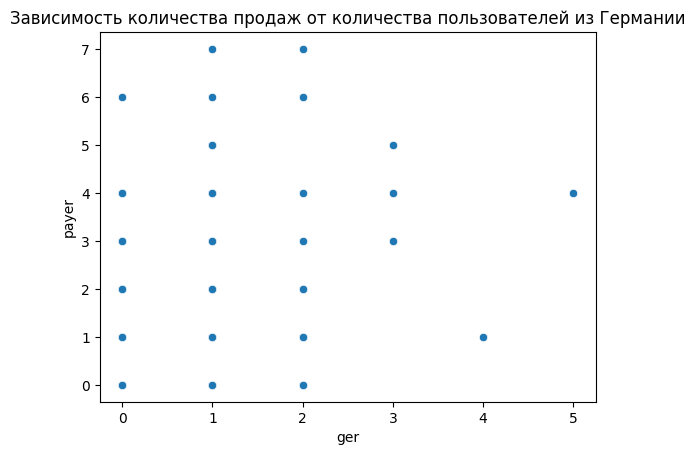

In [52]:
regr_df = regr_df.drop('fr', axis=1)
regr_df['ger'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['region'] == 'Germany']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['ger'])
plt.title('Зависимость количества продаж от количества пользователей из Германии')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

0.019


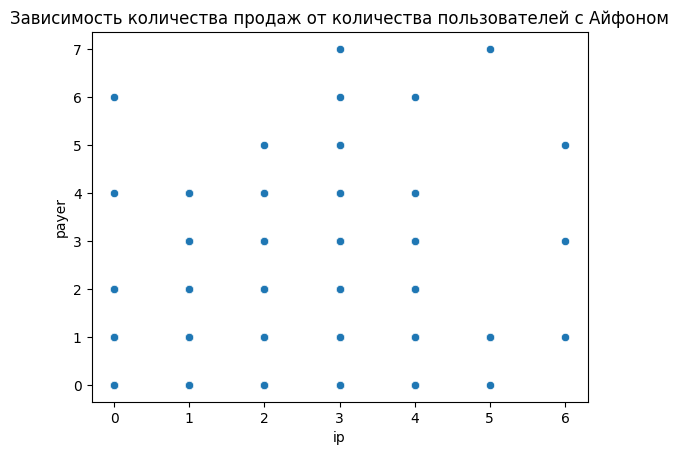

In [53]:
regr_df = regr_df.drop('ger', axis=1)
regr_df['ip'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['device'] == 'iPhone']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['ip'])
plt.title('Зависимость количества продаж от количества пользователей c Айфоном')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.164


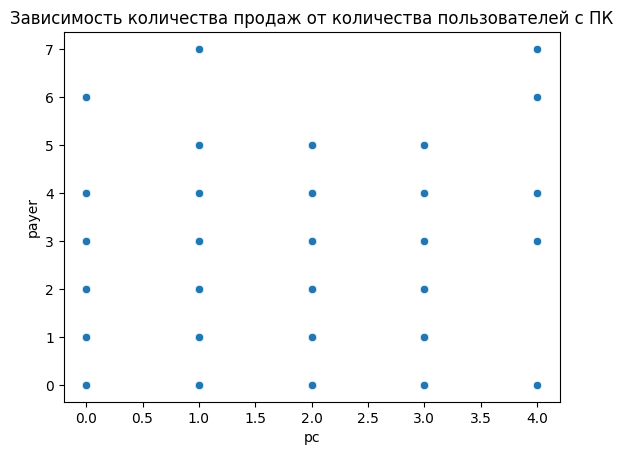

In [54]:
regr_df = regr_df.drop('ip', axis=1)
regr_df['pc'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['device'] == 'PC']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['pc'])
plt.title('Зависимость количества продаж от количества пользователей c ПК')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.032


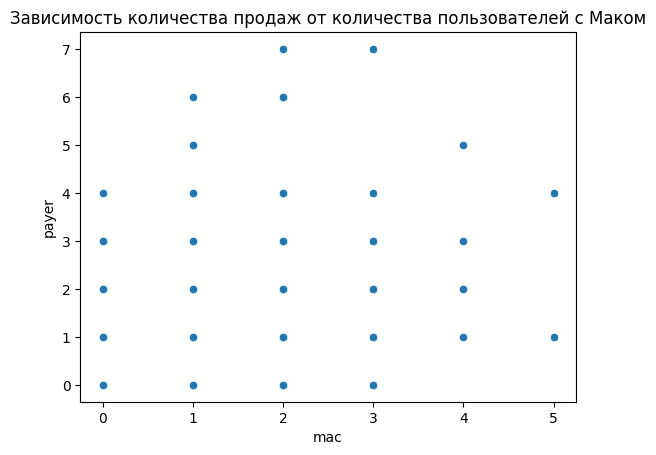

In [55]:
regr_df = regr_df.drop('pc', axis=1)
regr_df['mac'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['device'] == 'Mac']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['mac'])
plt.title('Зависимость количества продаж от количества пользователей c Маком')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.189


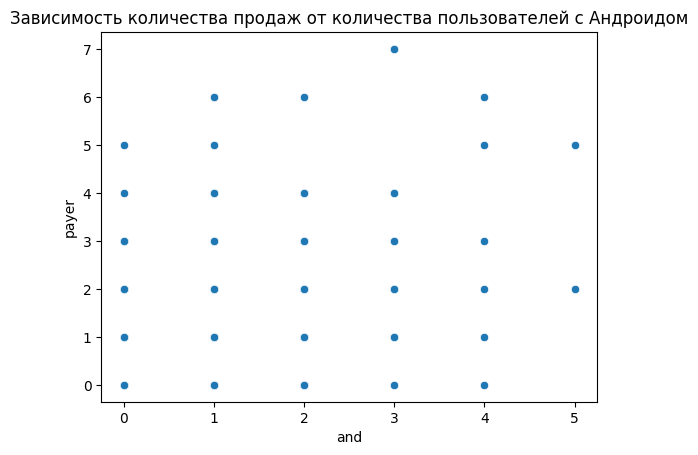

In [56]:
regr_df = regr_df.drop('mac', axis=1)
regr_df['and'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['device'] == 'Android']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['and'])
plt.title('Зависимость количества продаж от количества пользователей c Андроидом')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.141


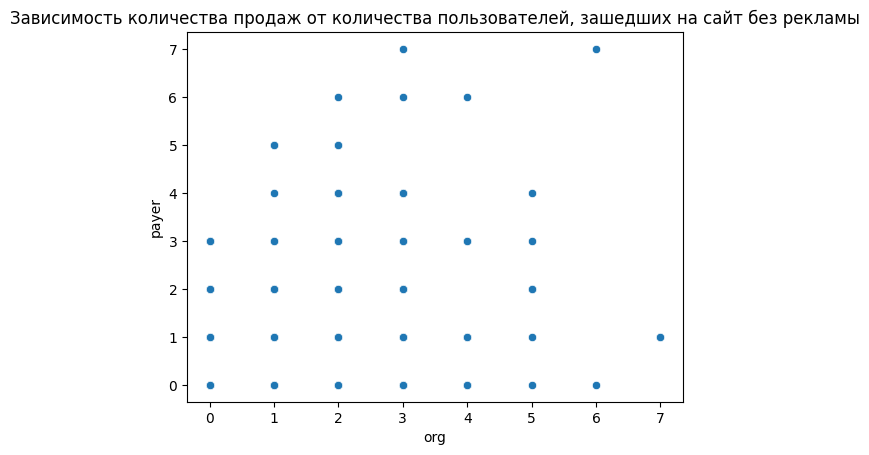

In [57]:
regr_df = regr_df.drop('and', axis=1)
regr_df['org'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['channel'] == 'organic']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['org'])
plt.title('Зависимость количества продаж от количества пользователей, зашедших на сайт без рекламы')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

0.076


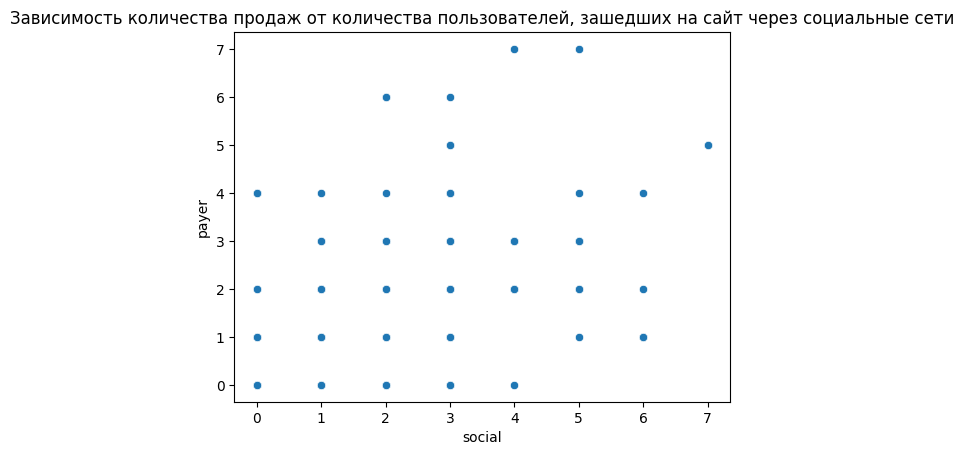

In [58]:
regr_df = regr_df.drop('org', axis=1)
regr_df['social'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['channel'] == 'социальные сети']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['social'])
plt.title('Зависимость количества продаж от количества пользователей, зашедших на сайт через социальные сети')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.054


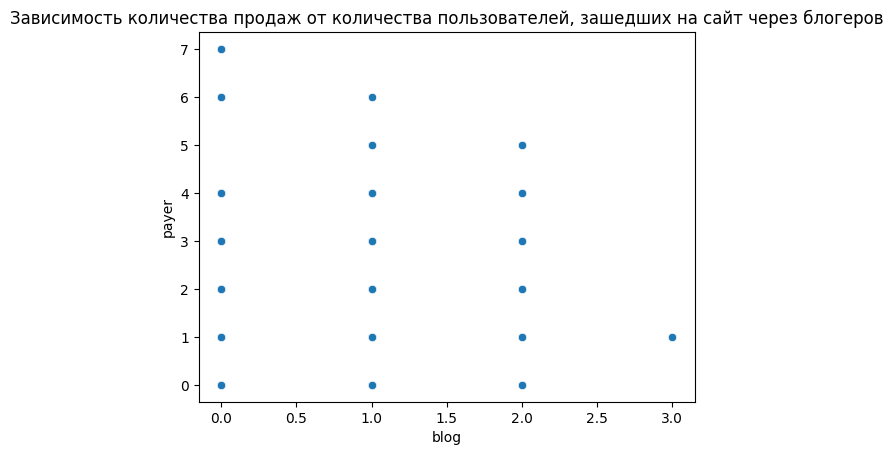

In [59]:
regr_df = regr_df.drop('social', axis=1)
regr_df['blog'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['channel'] == 'реклама у блогеров']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['blog'])
plt.title('Зависимость количества продаж от количества пользователей, зашедших на сайт через блогеров')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.104


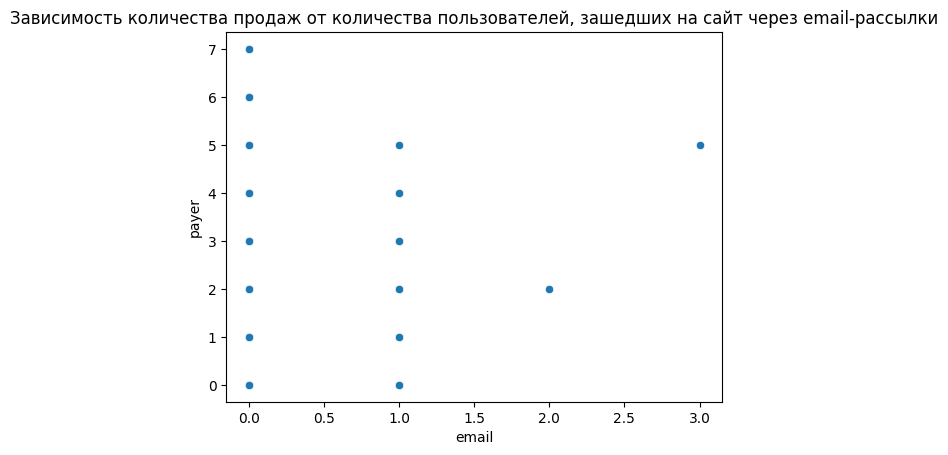

In [60]:
regr_df = regr_df.drop('blog', axis=1)
regr_df['email'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['channel'] == 'email-рассылки']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['email'])
plt.title('Зависимость количества продаж от количества пользователей, зашедших на сайт через email-рассылки')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.288


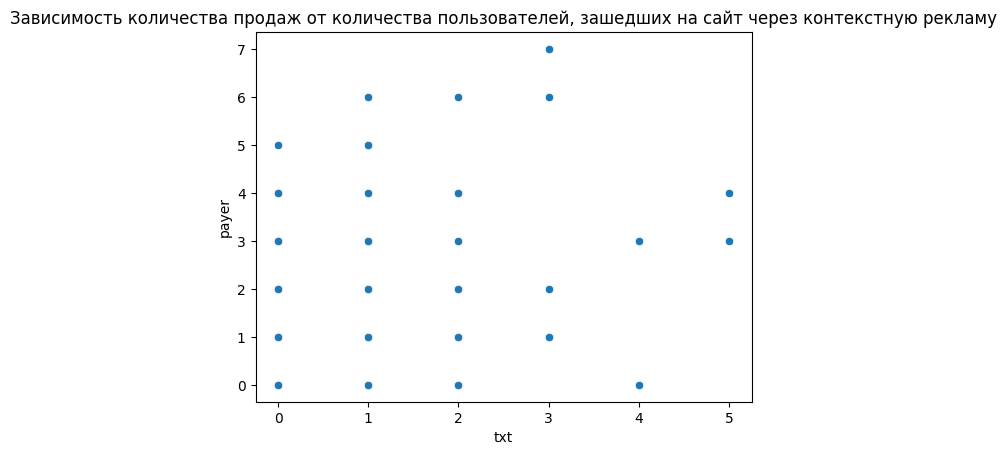

In [61]:
regr_df = regr_df.drop('email', axis=1)
regr_df['txt'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['channel'] == 'контекстная реклама']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['txt'])
plt.title('Зависимость количества продаж от количества пользователей, зашедших на сайт через контекстную рекламу')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

0.037


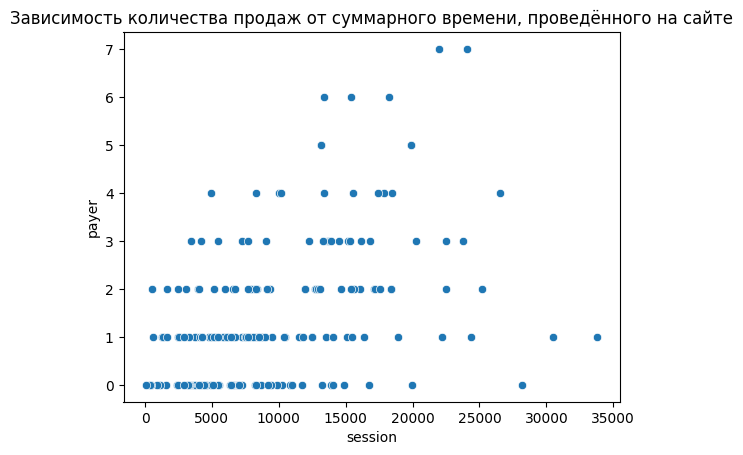

In [62]:
regr_df = regr_df.drop('txt', axis=1)
regr_df['session'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]['sessiondurationsec'].astype(float).sum())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['session'])
plt.title('Зависимость количества продаж от суммарного времени, проведённого на сайте')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.069


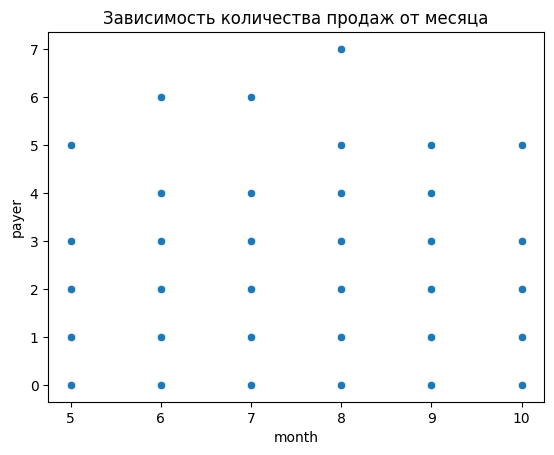

In [63]:
regr_df = regr_df.drop('session', axis=1)
regr_df['month'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]['month'].iloc[0])
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['month'])
plt.title('Зависимость количества продаж от месяца')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.085


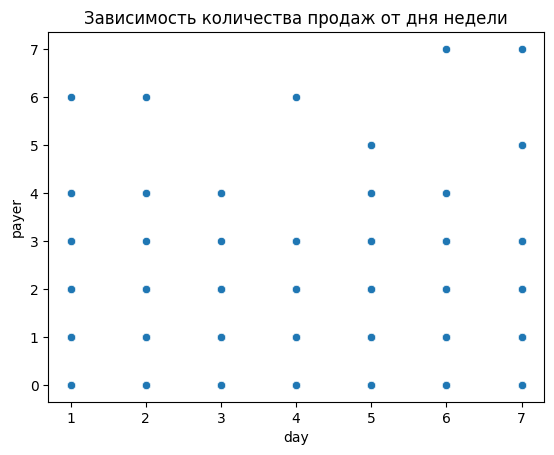

In [64]:
regr_df = regr_df.drop('month', axis=1)
regr_df['day'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]['day'].iloc[0])
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['day'])
plt.title('Зависимость количества продаж от дня недели')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.069


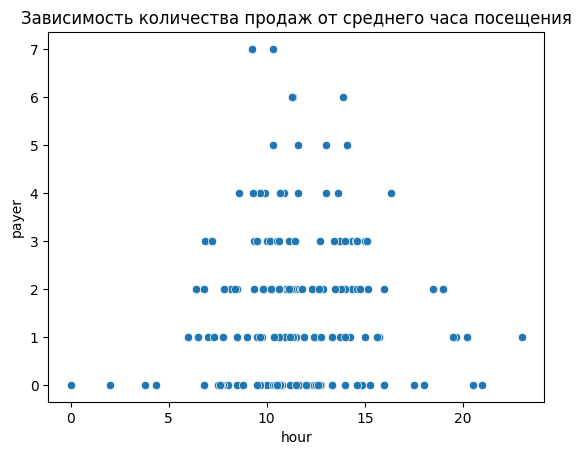

In [65]:
regr_df = regr_df.drop('day', axis=1)
regr_df['hour'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]['hour_of_day'].sum() / df
                                              .loc[df['session_date'] == x]['hour_of_day'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['hour'])
plt.title('Зависимость количества продаж от среднего часа посещения')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.09


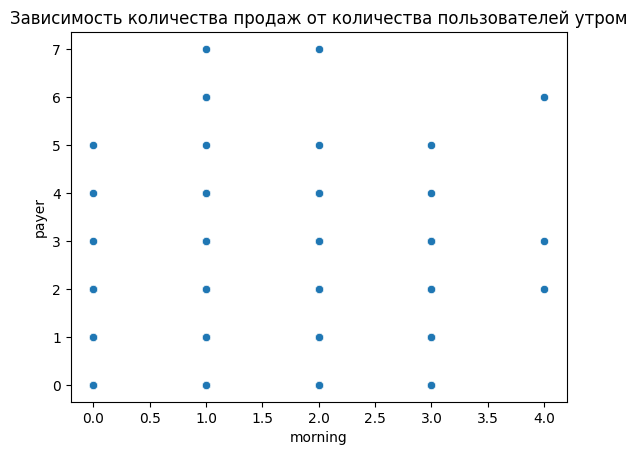

In [66]:
regr_df = regr_df.drop('hour', axis=1)
regr_df['morning'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['time_factor'] == 'утро']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['morning'])
plt.title('Зависимость количества продаж от количества пользователей утром')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

0.032


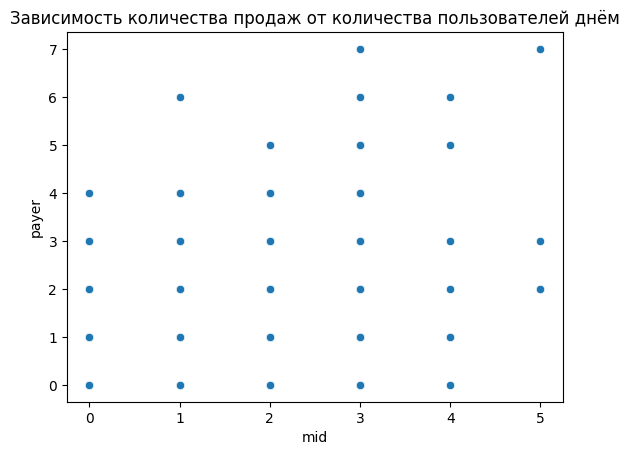

In [67]:
regr_df = regr_df.drop('morning', axis=1)
regr_df['mid'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['time_factor'] == 'день']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['mid'])
plt.title('Зависимость количества продаж от количества пользователей днём')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.086


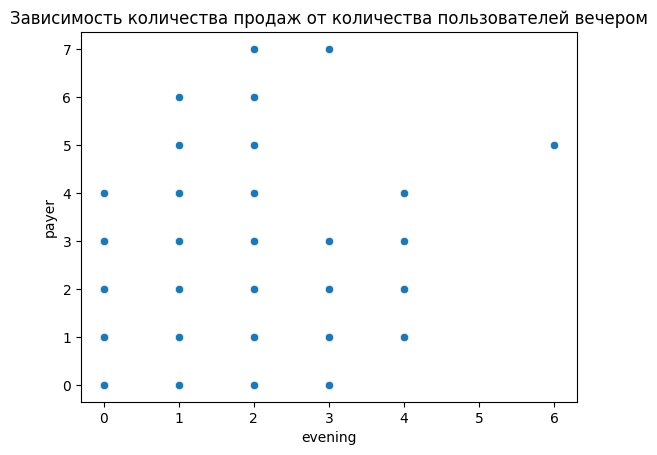

In [68]:
regr_df = regr_df.drop('mid', axis=1)
regr_df['evening'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['time_factor'] == 'вечер']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['evening'])
plt.title('Зависимость количества продаж от количества пользователей вечером')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

-0.197


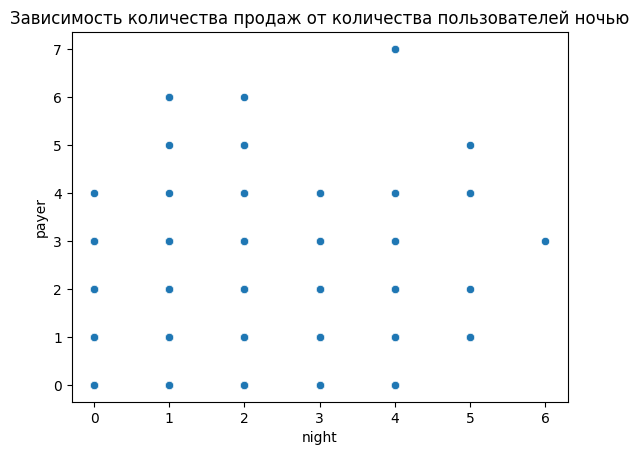

In [69]:
regr_df = regr_df.drop('evening', axis=1)
regr_df['night'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['time_factor'] == 'ночь']['user_id'].count())
sns.scatterplot(data=regr_df, y=regr_df['payer'], x=regr_df['night'])
plt.title('Зависимость количества продаж от количества пользователей ночью')
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

In [70]:
regr_df = regr_df.drop('night', axis=1)
regr_df['ip'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['device'] == 'iPhone']['user_id'].count())
regr_df['social'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['channel'] == 'социальные сети']['user_id'].count())
regr_df['session'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]['sessiondurationsec'].astype(float).sum())
regr_df['mid'] = regr_df['session_date'].apply(lambda x: df.loc[df['session_date'] == x]
                                             .loc[df['time_factor'] == 'день']['user_id'].count())
x_train, x_test, y_train, y_test = train_test_split(regr_df.drop(['payer', 'session_date'], axis=1), regr_df['payer'],
                                                    test_size=0.15, random_state=42)
lin_regr = LinearRegression()
lin_regr.fit(x_train, y_train)
prediction = lin_regr.predict(x_test)
print(round(r2_score(y_test, prediction), 3))

0.138


# Выводы

[график продаж по источникам](img/pie/channel_shared_sales_pie.png)

In [15]:
print(df.groupby(['region', 'channel'])[['region', 'channel']].value_counts())

region         channel            
France         email-рассылки          11
               organic                 29
               контекстная реклама     43
               реклама у блогеров      18
Germany        email-рассылки           5
               organic                 34
               контекстная реклама     43
               реклама у блогеров      20
UK             email-рассылки           7
               organic                 33
               контекстная реклама     51
               реклама у блогеров      23
United States  organic                247
               контекстная реклама     22
               реклама у блогеров      37
               социальные сети        380
Name: count, dtype: int64


In [5]:
df = pd.read_csv('resolvedData.csv')
data = df.groupby('region').apply(lambda x: round(x.loc[x['payer'] == 1]['payer'].value_counts().iloc[0] / 
                                                  x.loc[x['payer'] == 0]['payer'].value_counts().iloc[0] * 100, 1))
print(data)

region
France           29.5
Germany          30.8
UK               37.3
United States    41.2
dtype: float64
